In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('15/2/2019', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')
THIRD_SLICE_DATE: datetime = datetime.strptime('30/11/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

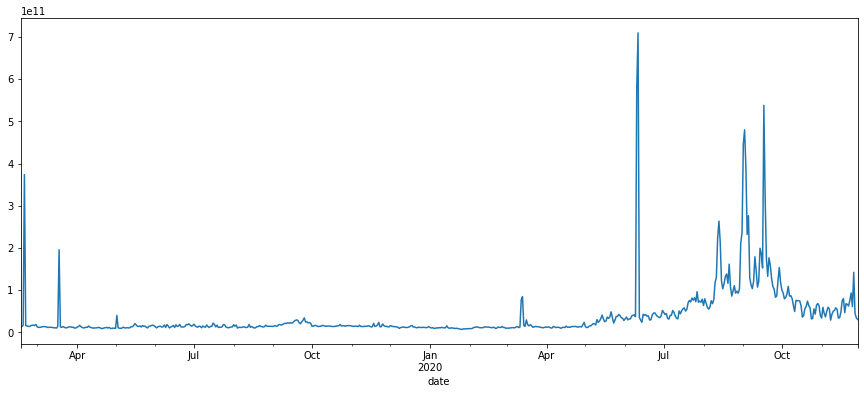

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

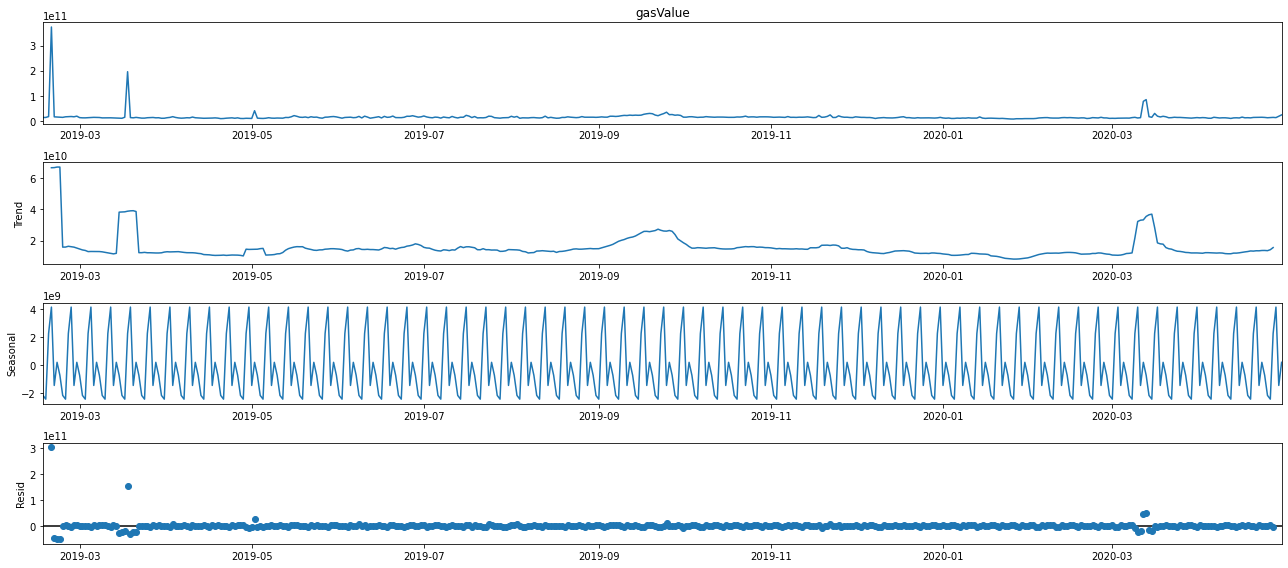

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

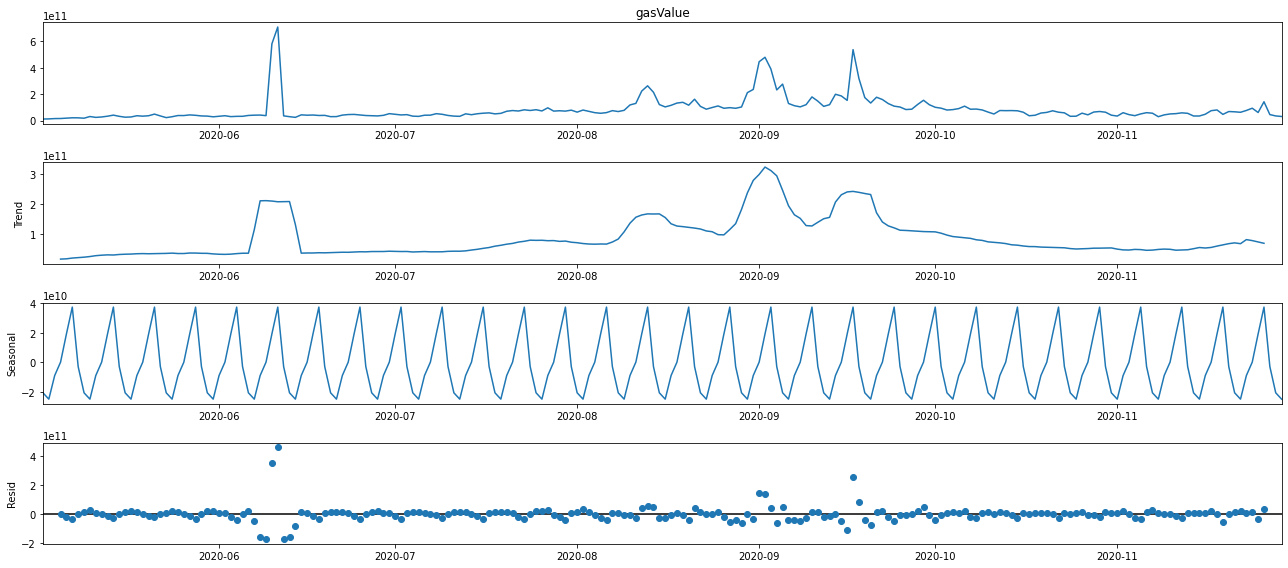

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

Let's apply a log transformation to reduce higher gasValue, and also remove the weekly seasonality.

In [12]:
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal

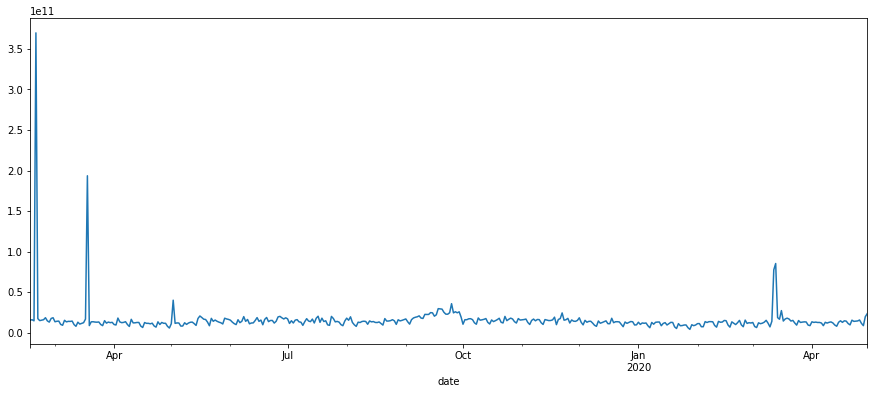

In [13]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [14]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal

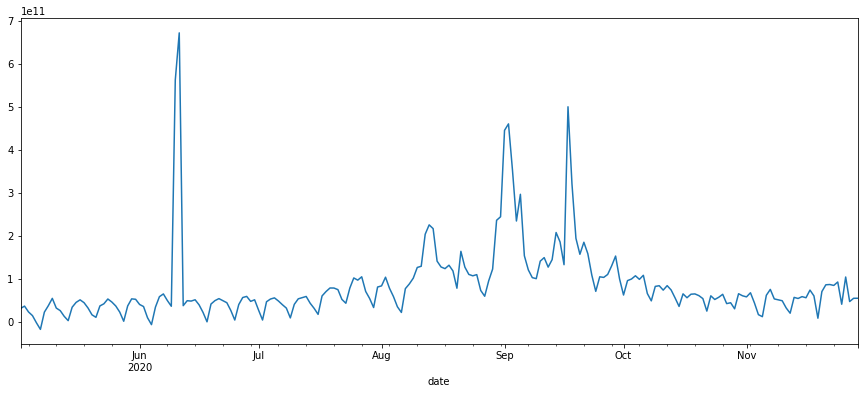

In [15]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [16]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -19.815960
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     439.000000
Critical Value (1%)      -3.445334
Critical Value (5%)      -2.868146
Critical Value (10%)     -2.570289
dtype: float64


In [17]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.601755
P-Value                   0.000128
# Lags Used               2.000000
# Observations Used     209.000000
Critical Value (1%)      -3.462032
Critical Value (5%)      -2.875471
Critical Value (10%)     -2.574195
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [18]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.40432236167602564
p-value: 0.07529208548447171
num lags: 3
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In [19]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.39755628912161994
p-value: 0.07820849606826727
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In both cases, p-gasValue are greater than 0.05, and "KPSS Statistic" gasValue are less than the critical gasValue. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# DAOhaus activity series

Let's check what about the activity series.

In [20]:
daohaus: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'daohaus_activity.csv'), header=0)
daohaus = transform_date_series(df=daohaus, date_key='date')

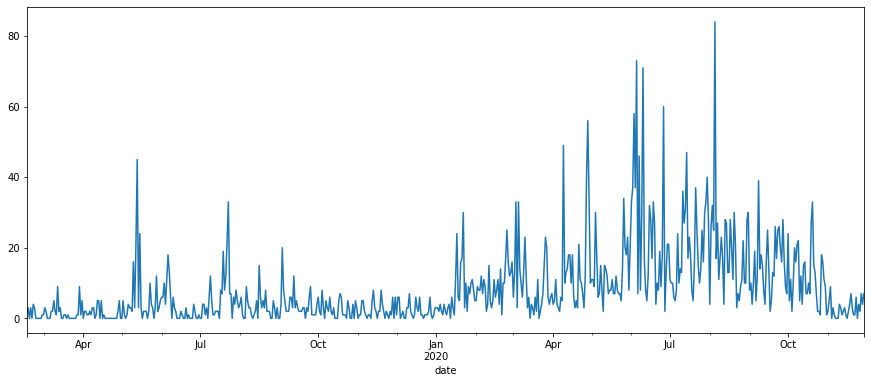

In [21]:
daohaus_plot = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=THIRD_SLICE_DATE)
daohaus_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [22]:
daohaus_slice1 = filter_series(df=daohaus, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
daohaus_slice2 = filter_series(df=daohaus, slice1=SECOND_SLICE_DATE, slice2=THIRD_SLICE_DATE)

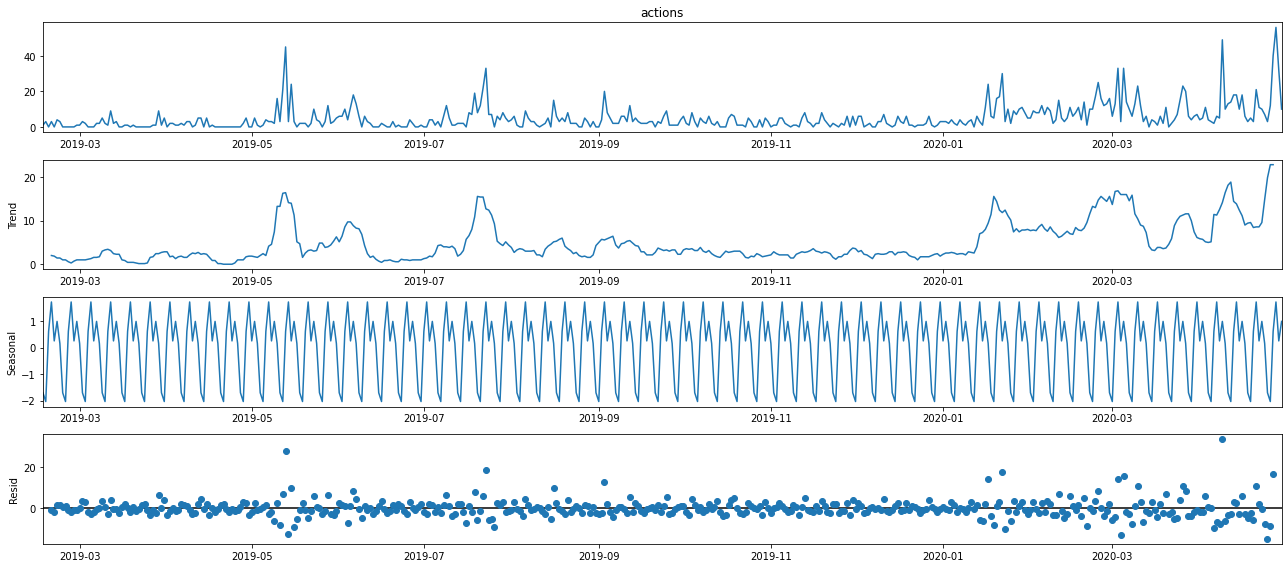

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=daohaus_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

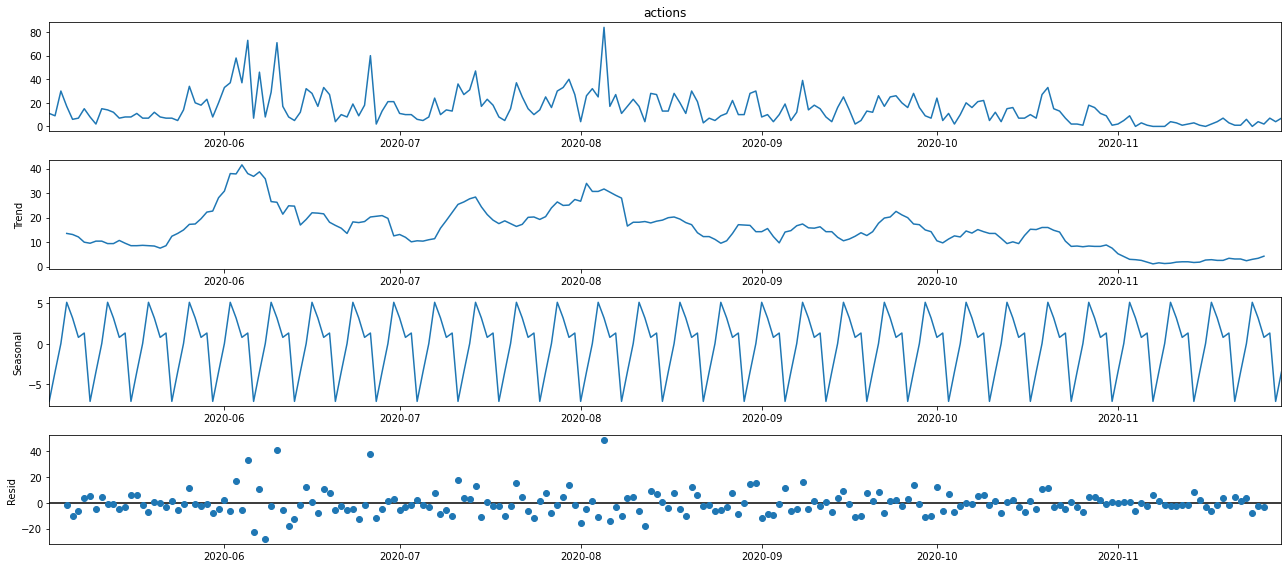

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=daohaus_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [25]:
daohaus_slice1['actions'] = daohaus_slice1['actions'] - decomposition1.seasonal
daohaus_slice1.dropna(inplace=True)

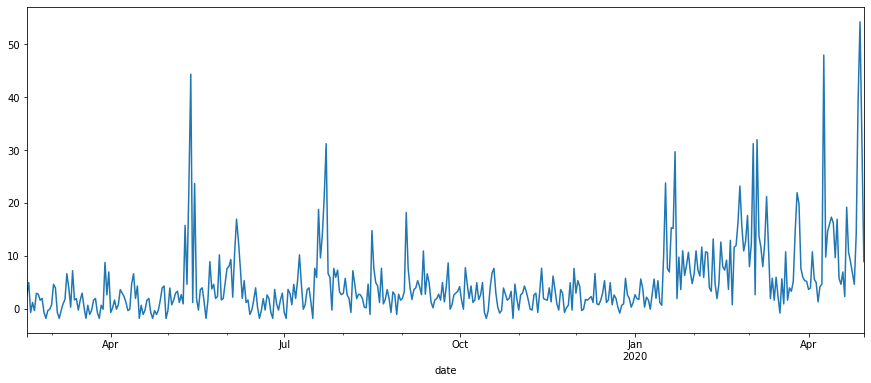

In [26]:
daohaus_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [27]:
daohaus_slice2['actions'] = daohaus_slice2['actions'] - decomposition2.seasonal
daohaus_slice2.dropna(inplace=True)

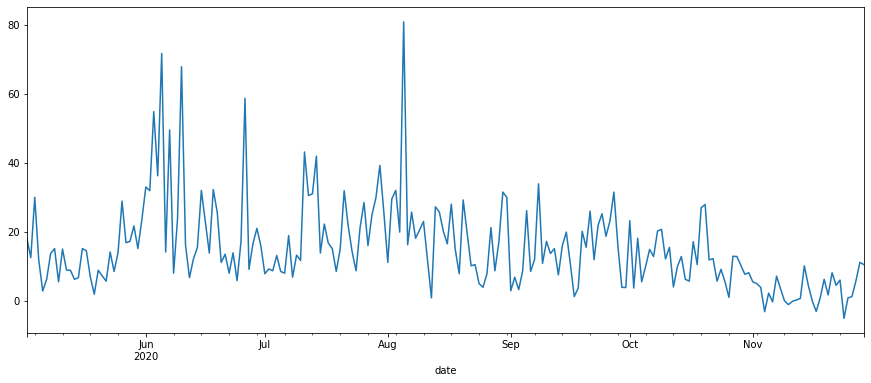

In [28]:
daohaus_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [29]:
print_adf(df=daohaus_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.495538
P-Value                   0.000200
# Lags Used               4.000000
# Observations Used     435.000000
Critical Value (1%)      -3.445473
Critical Value (5%)      -2.868207
Critical Value (10%)     -2.570321
dtype: float64


In [30]:
print_adf(df=daohaus_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.696506
P-Value                   0.000085
# Lags Used               2.000000
# Observations Used     209.000000
Critical Value (1%)      -3.462032
Critical Value (5%)      -2.875471
Critical Value (10%)     -2.574195
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical gasValue. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [31]:
print_kpss(df=daohaus_slice1, key='actions')

KPSS Statistic: 1.451493518117901
p-value: 0.01
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [32]:
print_kpss(df=daohaus_slice2, key='actions')

KPSS Statistic: 0.8833322973618887
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both series have gasValue that suggest that we fail to reject H0. So, it is definitely a stationary series.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [33]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': daohaus_slice1['actions'].tolist(),
     'gasPrice': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8630  , p=0.1730  , df_denom=436, df_num=1
ssr based chi2 test:   chi2=1.8759  , p=0.1708  , df=1
likelihood ratio test: chi2=1.8719  , p=0.1713  , df=1
parameter F test:         F=1.8630  , p=0.1730  , df_denom=436, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7982  , p=0.4508  , df_denom=433, df_num=2
ssr based chi2 test:   chi2=1.6147  , p=0.4460  , df=2
likelihood ratio test: chi2=1.6118  , p=0.4467  , df=2
parameter F test:         F=0.7982  , p=0.4508  , df_denom=433, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6081  , p=0.6100  , df_denom=430, df_num=3
ssr based chi2 test:   chi2=1.8541  , p=0.6032  , df=3
likelihood ratio test: chi2=1.8502  , p=0.6041  , df=3
parameter F test:         F=0.6081  , p=0.6100  , df_denom=430, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6317  , p=0.6401  

In [34]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': daohaus_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1373  , p=0.1453  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=2.1681  , p=0.1409  , df=1
likelihood ratio test: chi2=2.1571  , p=0.1419  , df=1
parameter F test:         F=2.1373  , p=0.1453  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4694  , p=0.0871  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=5.0593  , p=0.0797  , df=2
likelihood ratio test: chi2=4.9993  , p=0.0821  , df=2
parameter F test:         F=2.4694  , p=0.0871  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9096  , p=0.1292  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=5.9273  , p=0.1152  , df=3
likelihood ratio test: chi2=5.8448  , p=0.1194  , df=3
parameter F test:         F=1.9096  , p=0.1292  , df_denom=202, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2924  , p=0.0609  

With a lag of 1, p=0.0001, so we can reject H0, and acept that gasValue granger cause the daohaus activity.

# VAR analysis

## Slice 1

In [35]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = daohaus_slice1['actions'].tolist()

In [36]:
model1 = VAR(slice1)
model1.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,50.08,50.10,5.626e+21,50.09
1,49.79,49.85*,4.210e+21,49.81
2,49.76*,49.85,4.074e+21*,49.80*
3,49.77,49.90,4.123e+21,49.82
4,49.78,49.95,4.168e+21,49.85
5,49.78,49.99,4.151e+21,49.86
6,49.79,50.04,4.214e+21,49.89
7,49.81,50.09,4.272e+21,49.92
8,49.82,50.15,4.346e+21,49.95
9,49.84,50.20,4.417e+21,49.98


In [37]:
results1 = model1.fit(maxlags=2, ic='aic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     15:50:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    51.0995
Nobs:                     438.000    HQIC:                   51.0431
Log likelihood:          -12403.4    FPE:                1.41832e+22
AIC:                      51.0063    Det(Omega_mle):     1.38648e+22
--------------------------------------------------------------------
Results for equation gasValue
                    coefficient         std. error           t-stat            prob
-----------------------------------------------------------------------------------
const        15065930367.456585  1686699550.661451            8.932           0.000
L1.gasValue            0.050226           0.048087            1.044           0.296
L1.actions    -205227355.250359   159951656.1

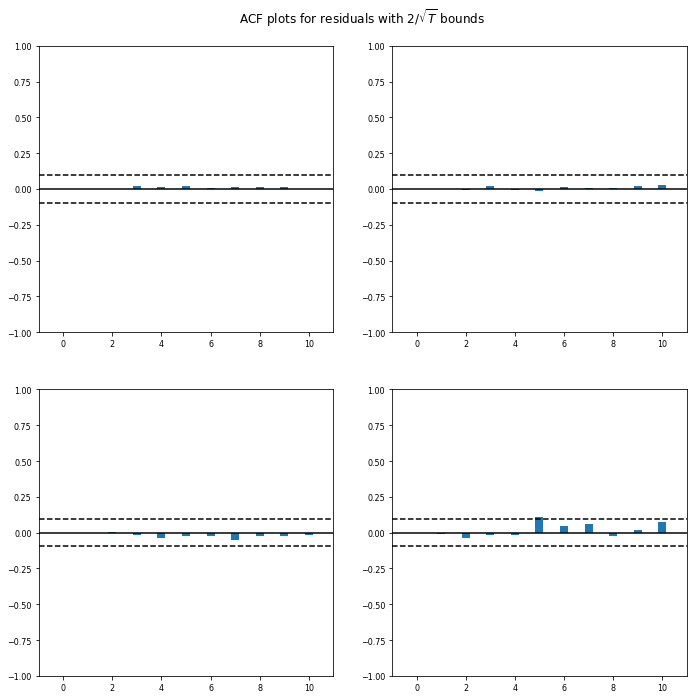

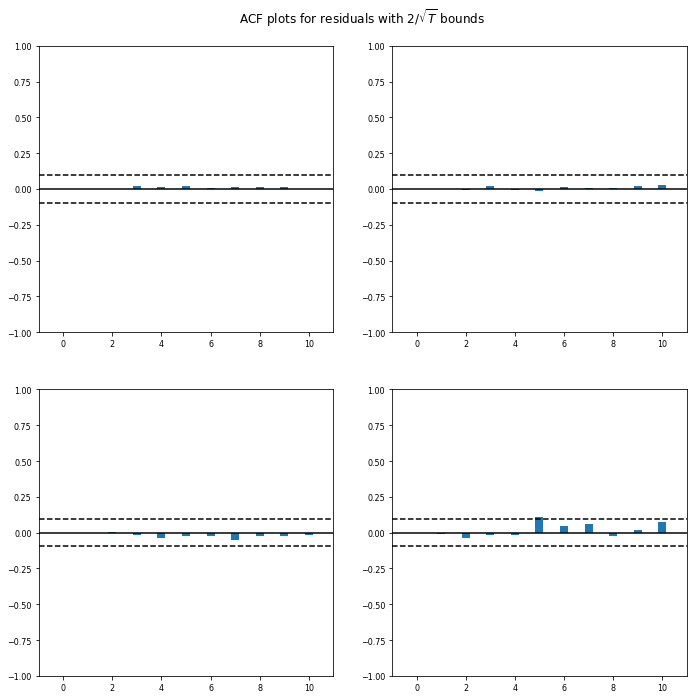

In [38]:
results1.plot_acorr()

### Impulse Response

In [39]:
irf1 = results1.irf(20)

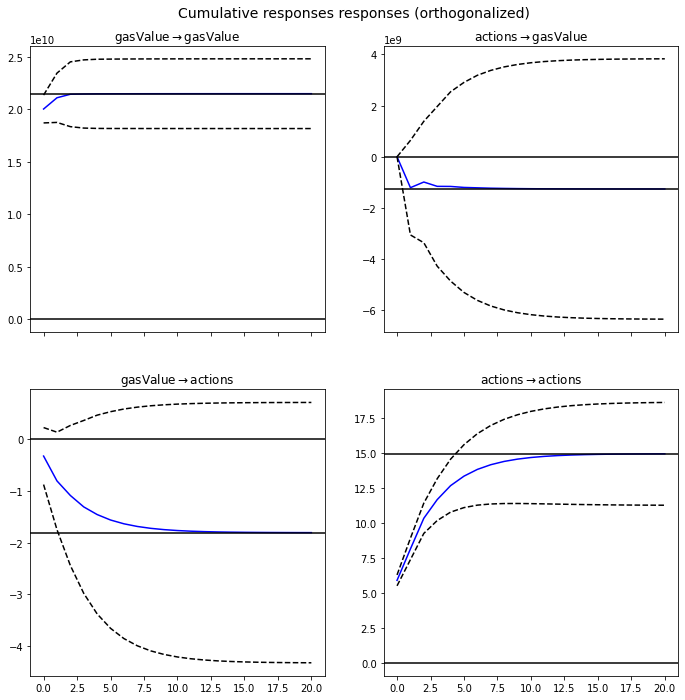

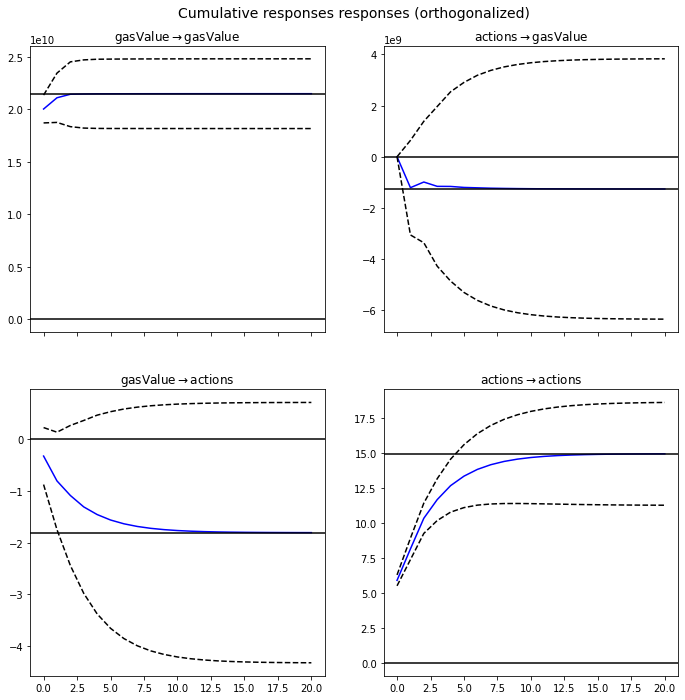

In [40]:
irf1.plot_cum_effects(orth=True)

In [41]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.996388  0.003612
2     0.996270  0.003730
3     0.996200  0.003800
4     0.996199  0.003801
5     0.996196  0.003804
6     0.996195  0.003805
7     0.996195  0.003805
8     0.996194  0.003806
9     0.996194  0.003806
10    0.996194  0.003806
11    0.996194  0.003806
12    0.996194  0.003806
13    0.996194  0.003806
14    0.996194  0.003806
15    0.996194  0.003806
16    0.996194  0.003806
17    0.996194  0.003806
18    0.996194  0.003806
19    0.996194  0.003806

FEVD for actions
      gasValue   actions
0     0.003037  0.996963
1     0.008425  0.991575
2     0.009283  0.990717
3     0.009967  0.990033
4     0.010212  0.989788
5     0.010345  0.989655
6     0.010405  0.989595
7     0.010435  0.989565
8     0.010450  0.989550
9     0.010457  0.989543
10    0.010461  0.989539
11    0.010462  0.989538
12    0.010463  0.989537
13    0.010464  0.989536
14    0.010464  0.989536
15    0.010464  0.989536
16    0.010464

In [42]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
1.052e+06,9.488,0.000,4


In [43]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
39.06,92.81,0.999,72


In [44]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
1.326,3.841,0.249,1


In [45]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.7982,3.006,0.450,"(2, 866)"


## Slice 2

In [46]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = daohaus_slice2['actions'].tolist()

In [47]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(15).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,55.62,55.65,1.431e+24,55.63
1,54.89,54.99,6.925e+23,54.94
2,54.80,54.97*,6.297e+23,54.87
3,54.74*,54.98,5.951e+23*,54.84*
4,54.76,55.06,6.068e+23,54.88
5,54.77,55.14,6.125e+23,54.92
6,54.80,55.23,6.309e+23,54.98
7,54.83,55.33,6.495e+23,55.03
8,54.85,55.42,6.621e+23,55.08
9,54.88,55.52,6.866e+23,55.14


In [48]:
results2 = model2.fit(maxlags=3, ic='aic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jan, 2021
Time:                     15:50:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    54.8726
Nobs:                     209.000    HQIC:                   54.7392
Log likelihood:          -6289.90    FPE:                5.41550e+23
AIC:                      54.6487    Det(Omega_mle):     5.07018e+23
--------------------------------------------------------------------
Results for equation gasValue
                    coefficient         std. error           t-stat            prob
-----------------------------------------------------------------------------------
const        15757034555.709938  9651560492.339901            1.633           0.103
L1.gasValue            0.788418           0.068790           11.461           0.000
L1.actions     541899911.109369   394616338.0

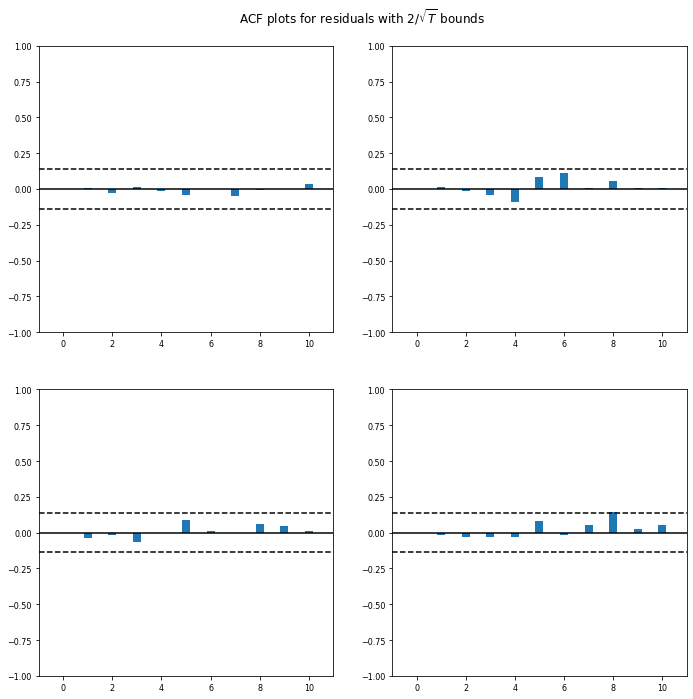

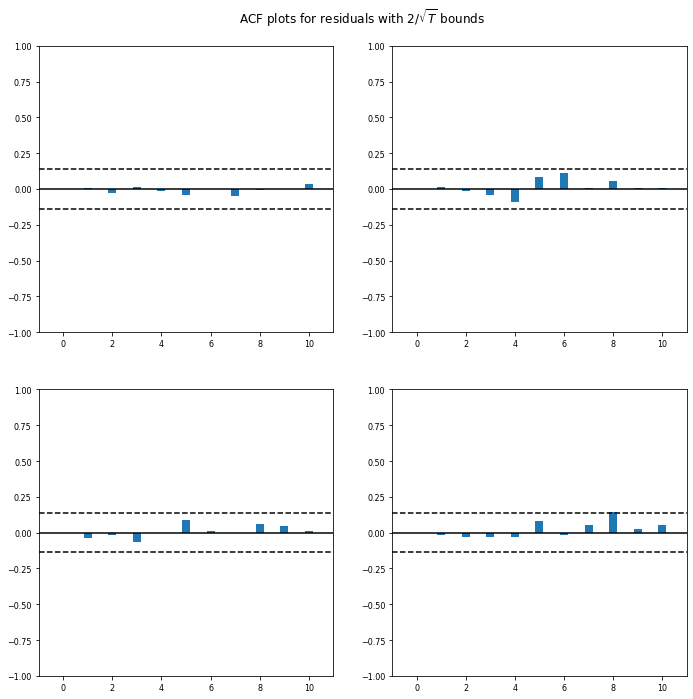

In [49]:
results2.plot_acorr()

### Impulse Response

In [50]:
irf2 = results2.irf(20)

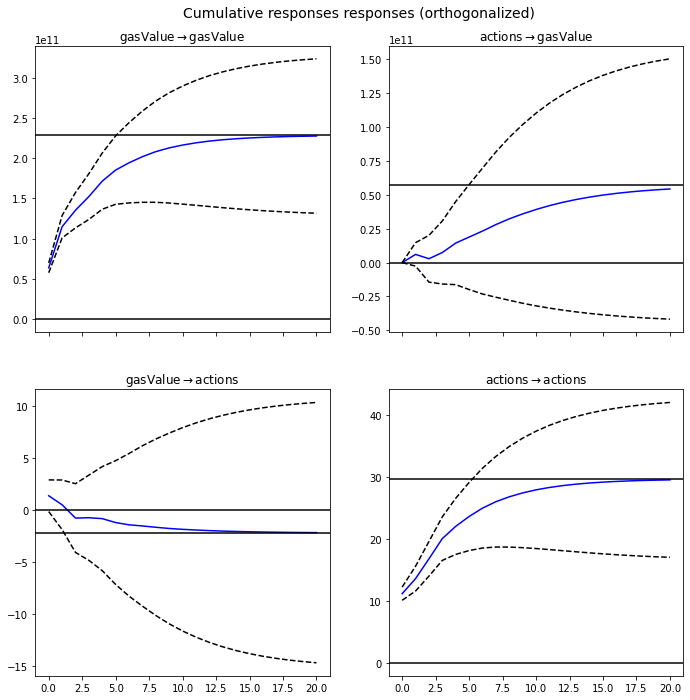

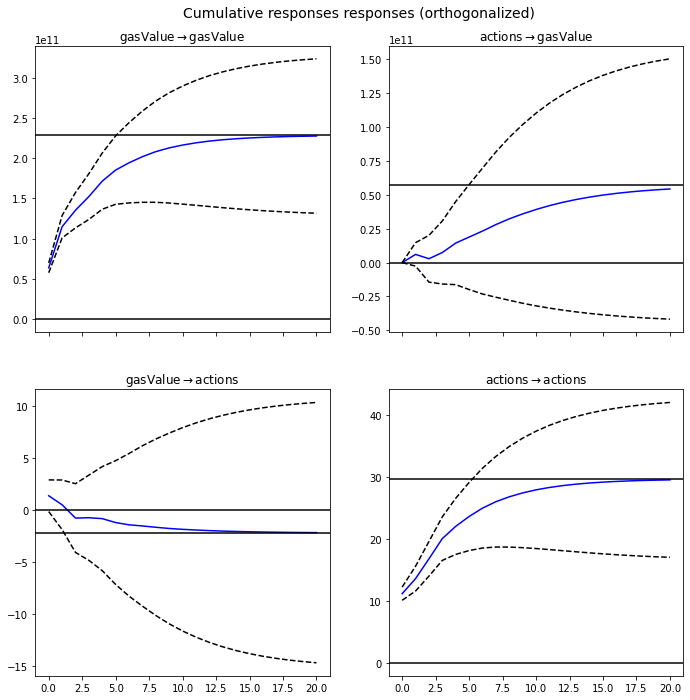

In [51]:
irf2.plot_cum_effects(orth=True)

In [52]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.994541  0.005459
2     0.993448  0.006552
3     0.990893  0.009107
4     0.985229  0.014771
5     0.983167  0.016833
6     0.980976  0.019024
7     0.978380  0.021620
8     0.976368  0.023632
9     0.974885  0.025115
10    0.973694  0.026306
11    0.972768  0.027232
12    0.972090  0.027910
13    0.971598  0.028402
14    0.971241  0.028759
15    0.970986  0.029014
16    0.970806  0.029194
17    0.970681  0.029319
18    0.970594  0.029406
19    0.970534  0.029466

FEVD for actions
      gasValue   actions
0     0.014805  0.985195
1     0.019713  0.980287
2     0.029311  0.970689
3     0.027306  0.972694
4     0.026682  0.973318
5     0.027114  0.972886
6     0.027090  0.972910
7     0.026985  0.973015
8     0.026974  0.973026
9     0.026989  0.973011
10    0.026990  0.973010
11    0.026990  0.973010
12    0.026994  0.973006
13    0.026998  0.973002
14    0.027000  0.973000
15    0.027001  0.972999
16    0.027003

In [53]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
6081.,9.488,0.000,4


In [54]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
64.69,88.25,0.591,68


In [55]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
3.049,3.841,0.081,1
